## Notebook 1 - Standardize substrates

This notebook standardizes the substrate SMILES and calculates the expected m/z for the corresponding glucoconjugates.

In [ ]:
%run ../common.py

In [2]:
import re

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

In [ ]:
df_substrates = pd.read_csv('../data/screening_data/Substrates.csv')
df_substrates['Name'] = df_substrates['Name'].str.upper()
df_substrates

,Mix,Name,InchiKey,ik_MoNA,SMILES,RT
0,1,3ALPHA-HYDROXY-3-DEOXYANGOLENSIC ACID METHYL E...,QFRUZVNPYYYLAN-BBJYNIMOSA-N,QFRUZVNPYYYLAN,C[C@@]12CCC3C(=C)[C@]1(CC(=O)O[C@H]2C4=COC=C4)...,10.38
1,1,3-AMINO-BETA-PINENE,SQSDBXYJKLVZJR-UHFFFAOYSA-N,SQSDBXYJKLVZJR,CC1(C2CC1C(=C)C(C2)N)C.Cl,5.00
2,1,"3BETA-HYDROXY-23,24-BISNORCHOL-5-ENIC ACID",NPBNRBWMDNZEBN-YTEKVJICSA-N,NPBNRBWMDNZEBN,CC([C@H]1CCC2[C@@]1(CCC3C2CC=C4[C@@]3(CC[C@@H]...,13.75
3,1,3-HYDROXYTYRAMINE,VYFYYTLLBUKUHU-UHFFFAOYSA-N,VYFYYTLLBUKUHU,C1=CC(=C(C=C1CCN)O)O,11.47
4,1,AVOCADYNE ACETATE,JAKAZHIACKJNNB-UHFFFAOYSA-N,JAKAZHIACKJNNB,CC(=O)OCC(CC(CCCCCCCCCCCC#C)O)O,11.12
...,...,...,...,...,...,...
459,12,SPERMIDINE,ATHGHQPFGPMSJY-UHFFFAOYSA-N,ATHGHQPFGPMSJY,C(CCNCCCN)CN,0.63
460,12,STEVIOL,QFVOYBUQQBFCRH-VQSWZGCSSA-N,QFVOYBUQQBFCRH,C[C@@]12CCC[C@@]([C@H]1CC[C@]34[C@H]2CC[C@](C3...,11.15
461,12,STIGMASTEROL,HCXVJBMSMIARIN-PHZDYDNGSA-N,HCXVJBMSMIARIN,CC[C@H](/C=C/[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC...,NaN
462,12,TODDALOLACTONE,GLWPLQBQHWYKRK-UHFFFAOYSA-N,GLWPLQBQHWYKRK,CC(C)(C(CC1=C(C=C2C(=C1OC)C=CC(=O)O2)OC)O)O,6.60


In [10]:
df_substrates.InchiKey.nunique()

453

In [12]:
df_substrates.SMILES.nunique()

453

## Standardize SMILES

In [13]:
def standardize(smiles):
    '''Adapted from: https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/'''
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    # te = rdMolStandardize.TautomerEnumerator() # idem
    # taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return Chem.MolToSmiles(uncharged_parent_clean_mol, isomericSmiles=False, canonical=True) 

In [14]:
csmiles = []

for smi in df_substrates['SMILES']:
    csmi = standardize(smi)
    csmiles.append(csmi)

df_substrates['CSMILES'] = csmiles

In [15]:
df_substrates

,Mix,Name,InchiKey,ik_MoNA,SMILES,RT,CSMILES
0,1,3ALPHA-HYDROXY-3-DEOXYANGOLENSIC ACID METHYL E...,QFRUZVNPYYYLAN-BBJYNIMOSA-N,QFRUZVNPYYYLAN,C[C@@]12CCC3C(=C)[C@]1(CC(=O)O[C@H]2C4=COC=C4)...,10.38,C=C1C2CCC3(C)C(c4ccoc4)OC(=O)CC13OC1CC(O)C(C)(...
1,1,3-AMINO-BETA-PINENE,SQSDBXYJKLVZJR-UHFFFAOYSA-N,SQSDBXYJKLVZJR,CC1(C2CC1C(=C)C(C2)N)C.Cl,5.00,C=C1C(N)CC2CC1C2(C)C
2,1,"3BETA-HYDROXY-23,24-BISNORCHOL-5-ENIC ACID",NPBNRBWMDNZEBN-YTEKVJICSA-N,NPBNRBWMDNZEBN,CC([C@H]1CCC2[C@@]1(CCC3C2CC=C4[C@@]3(CC[C@@H]...,13.75,CC(C(=O)O)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
3,1,3-HYDROXYTYRAMINE,VYFYYTLLBUKUHU-UHFFFAOYSA-N,VYFYYTLLBUKUHU,C1=CC(=C(C=C1CCN)O)O,11.47,NCCc1ccc(O)c(O)c1
4,1,AVOCADYNE ACETATE,JAKAZHIACKJNNB-UHFFFAOYSA-N,JAKAZHIACKJNNB,CC(=O)OCC(CC(CCCCCCCCCCCC#C)O)O,11.12,C#CCCCCCCCCCCCC(O)CC(O)COC(C)=O
...,...,...,...,...,...,...,...
459,12,SPERMIDINE,ATHGHQPFGPMSJY-UHFFFAOYSA-N,ATHGHQPFGPMSJY,C(CCNCCCN)CN,0.63,NCCCCNCCCN
460,12,STEVIOL,QFVOYBUQQBFCRH-VQSWZGCSSA-N,QFVOYBUQQBFCRH,C[C@@]12CCC[C@@]([C@H]1CC[C@]34[C@H]2CC[C@](C3...,11.15,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(O)C3
461,12,STIGMASTEROL,HCXVJBMSMIARIN-PHZDYDNGSA-N,HCXVJBMSMIARIN,CC[C@H](/C=C/[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC...,NaN,CCC(C=CC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C...
462,12,TODDALOLACTONE,GLWPLQBQHWYKRK-UHFFFAOYSA-N,GLWPLQBQHWYKRK,CC(C)(C(CC1=C(C=C2C(=C1OC)C=CC(=O)O2)OC)O)O,6.60,COc1cc2oc(=O)ccc2c(OC)c1CC(O)C(C)(C)O


## Compute expected m/z for substrates

We consider that the substrate can form different adducts (https://fiehnlab.ucdavis.edu/staff/kind/metabolomics/ms-adduct-calculator/).

Also note that we will override any precursor m/z in MoNA, assuming that the type of adduct does not affect significantly the fragmentation pattern in MS2.

In [16]:
#Adapted from https://stackoverflow.com/questions/30334385/display-svg-in-ipython-notebook-from-a-function
    
def moltosvg(mol, molSize = (300,300), kekulize = False):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

Positive charge (+1) in COc1cc2c3cc1Oc1cc(ccc1O)CC1c4c(cc(OC)c(O)c4Oc4ccc(cc4)CC3N(C)CC2)CC[N+]1(C)C


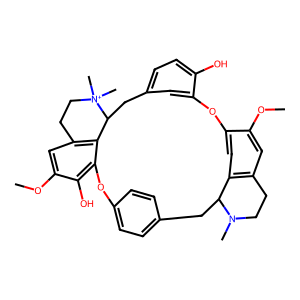

Positive charge (+1) in C=C1CCCC(C)(C)C1CCC(C)=CCCC(C)=CCn1c[n+](C)c2ncnc(N)c21


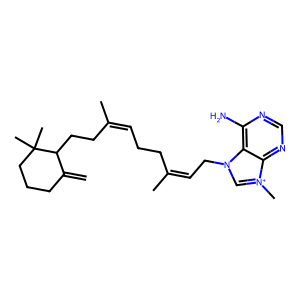

Positive charge (+1) in OCC1OC(Oc2cc3c(O)cc(O)cc3[o+]c2-c2ccc(O)c(O)c2)C(O)C(O)C1O


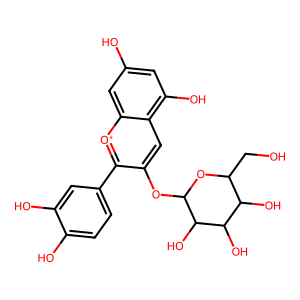

In [17]:
df_tmp = df_substrates.copy()

csmiles = df_substrates['CSMILES']

charges = []

expected_mz_H = []
expected_mz_Na = []
expected_mz_2H = []
expected_mz_NH4 = []
expected_mz_ACNH = []

expected_mz2_H = []
expected_mz2_Na = []
expected_mz2_2H = []
expected_mz2_NH4 = []
expected_mz2_ACNH = []

for csmi in csmiles:
    mol = MolFromSmiles(csmi)
    charge = Chem.rdmolops.GetFormalCharge(mol)
    mw = ExactMolWt(mol) + 162.0533
    mw2 = mw + 162.0533
    
    if charge == 0:
        expected_mz_H.append(mw + 1.007276)
        expected_mz_2H.append(mw/2 + 1.007276)
        expected_mz_Na.append(mw + 22.989218)
        expected_mz_NH4.append(mw + 18.033823)
        expected_mz_ACNH.append(mw + 42.033823)
        
        expected_mz2_H.append(mw2 + 1.007276)
        expected_mz2_2H.append(mw2/2 + 1.007276)
        expected_mz2_Na.append(mw2 + 22.989218)
        expected_mz2_NH4.append(mw2 + 18.033823)
        expected_mz2_ACNH.append(mw2 + 42.033823)
        
           
    elif charge > 0:
        print(f'Positive charge (+{charge}) in {csmi}')
        display(moltosvg(mol))
        expected_mz_H.append(mw)
        expected_mz_2H.append((mw + 1.007276)/(1. + charge))
        expected_mz_Na.append((mw + 22.989218)/(1. + charge))
        expected_mz_NH4.append((mw + 18.033823)/(1. + charge))
        expected_mz_ACNH.append((mw + 42.033823)/(1. + charge))
        
        expected_mz2_H.append(mw2)
        expected_mz2_2H.append((mw2 + 1.007276)/(1. + charge))
        expected_mz2_Na.append((mw2 + 22.989218)/(1. + charge))
        expected_mz2_NH4.append((mw2 + 18.033823)/(1. + charge))
        expected_mz2_ACNH.append((mw2 + 42.033823)/(1. + charge))
        
        
    else:
        print(f'Error: negative charge in {csmi}')
        break
        
    charges.append(charge)

df_substrates['M_charge'] = charges
df_substrates['M+Glu+H'] = expected_mz_H
df_substrates['M+Glu+Na'] = expected_mz_Na
df_substrates['M+Glu+2H'] = expected_mz_2H
df_substrates['M+Glu+NH4'] = expected_mz_NH4
df_substrates['M+ACN+H'] = expected_mz_ACNH

df_substrates['M+2Glu+H'] = expected_mz2_H
df_substrates['M+2Glu+Na'] = expected_mz2_Na
df_substrates['M+2Glu+2H'] = expected_mz2_2H
df_substrates['M+2Glu+NH4'] = expected_mz2_NH4
df_substrates['M+2Glu+ACN+H'] = expected_mz2_ACNH

In [18]:
df_substrates.drop(columns=['RT'], inplace=True)

In [ ]:
# Let us also add the substrate superclass

import urllib
import json

smiles = list(df_substrates['CSMILES'])
class_list = []
superclass_list = []
pathway_list = []
for smi in tqdm(smiles):
    try:
        with urllib.request.urlopen("https://npclassifier.ucsd.edu/classify?smiles=" + smi) as url:
            data = json.loads(url.read().decode("utf-8"))
            class_list.append(";".join(data['class_results']))
            superclass_list.append(";".join(data['superclass_results']))
            pathway_list.append(";".join(data['superclass_results']))
    except:
        print(f'SMILES request failed: {smi}')
        class_list.append(np.nan)
        superclass_list.append(np.nan)
        pathway_list.append(np.nan)

In [ ]:
df_substrates['superclass'] = superclass_list

In [19]:
df_substrates.to_csv('./tmp/Substrates_VB.csv', index=False)